# Stage I length binned gradient boosting classifier

Now that the data have been length binned and the feature engineering is complete, it's time to set-up the classifier. The plan is to train a separate XGBoost classifier for each fragment length bin.

## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

import pickle
# import h5py
# import pandas as pd
# from xgboost import XGBClassifier
from scipy.stats import uniform, randint
# from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import make_scorer

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import functions.length_binned_xgboost as xgb_funcs

Working directory: /mnt/arkk/llm_detector/classifier


Set some run parameters and file paths:

In [2]:
# The dataset to train on - omit the file extension, it will be added
dataset_name = 'falcon-7b_scores_v2_10-300_words_stage_I'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

# Number of folds to run for cross validation
cv_folds = 7

# Number of parameter sets to sample for hyperparameter optimization
hyperparameter_iterations = 100

# Paths to save and load results
cross_validation_results_filename = f'{config.DATA_PATH}/stage_one_cross_validation_results_{cv_folds}_folds.pkl'
cross_validation_control_results_filename = f'{config.DATA_PATH}/stage_one_cross_validation_control_results_{cv_folds}_folds.pkl'
hyperparameter_optimization_results_filename = f'{config.DATA_PATH}/stage_one_hyperparameter_optimization_results_{hyperparameter_iterations}_iterations.pkl'

## 2. Stage I classifiers: baseline performance

In [3]:
# Make evaluation metrics scorers
scoring_funcs = {
    'negated_binary_cross_entropy': make_scorer(helper_funcs.negated_binary_cross_entropy),
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

# Plots to draw
plots = ['Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

### 2.1. Cross-validation

Cross-validating bin_001_050
Cross-validating bin_026_075
Cross-validating bin_051_100
Cross-validating bin_076_125
Cross-validating bin_101_150
Cross-validating bin_126_175
Cross-validating bin_151_200
Cross-validating bin_176_225
Cross-validating bin_201_250
Cross-validating bin_226_275
Cross-validating bin_251_300
Cross-validating combined


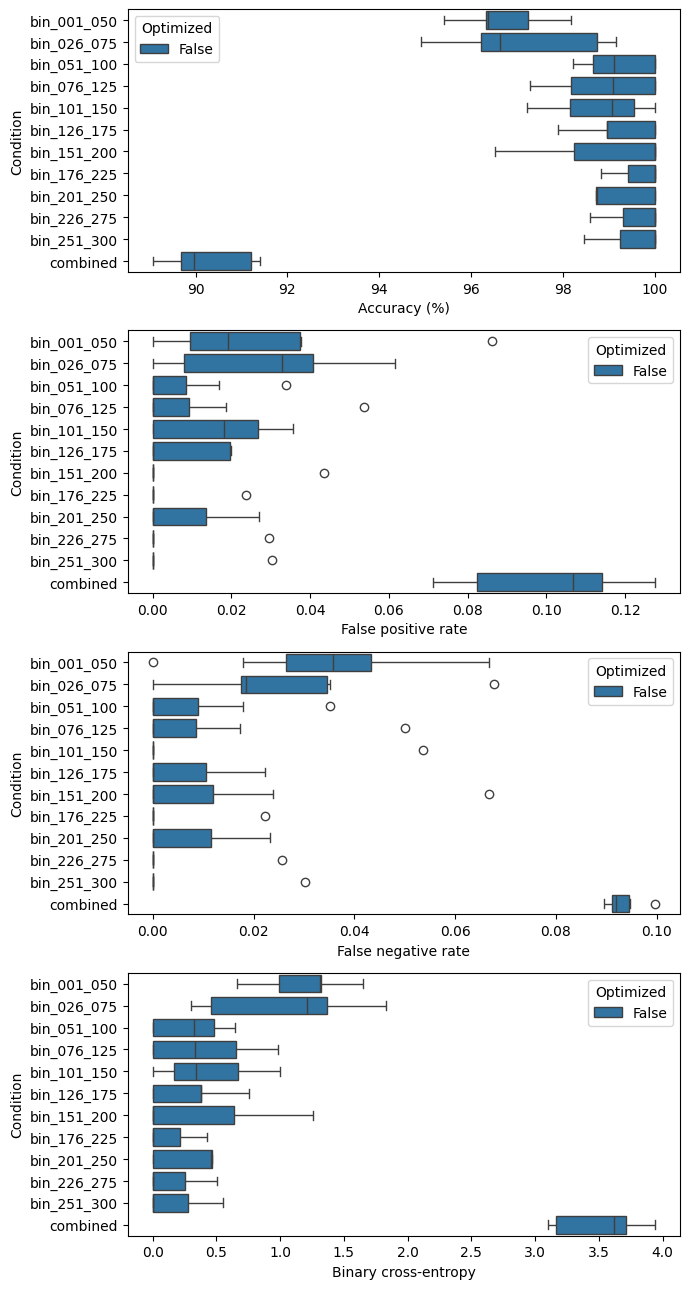

CPU times: user 2.77 s, sys: 1.4 s, total: 4.17 s
Wall time: 9.76 s


In [4]:
%%time

# Dictionary to hold testing/experimentation results
parsed_results = {
    'Fold': [],
    'Condition': [],
    'Optimized': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Do the cross-validation
parsed_results = xgb_funcs.cross_validate_bins(
    input_file = input_file,
    parsed_results = parsed_results,
    scoring_funcs = scoring_funcs,
    cv_folds = cv_folds,
    shuffle_control = False
)

# Save the result
with open(cross_validation_results_filename, 'wb') as result_output_file:
    pickle.dump(parsed_results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

# Plot the results
plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

### 2.2. Cross-validation: shuffled control

Cross-validating bin_001_050
Cross-validating bin_026_075
Cross-validating bin_051_100
Cross-validating bin_076_125
Cross-validating bin_101_150
Cross-validating bin_126_175
Cross-validating bin_151_200
Cross-validating bin_176_225
Cross-validating bin_201_250
Cross-validating bin_226_275
Cross-validating bin_251_300
Cross-validating combined


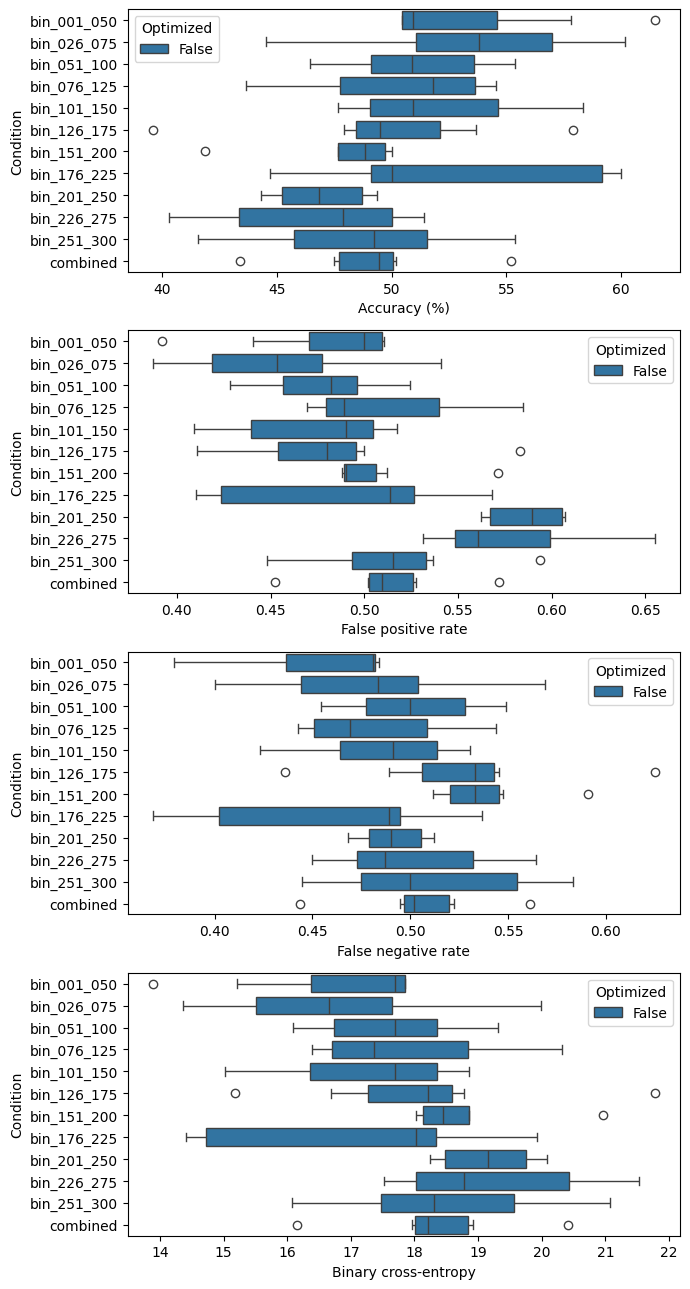

CPU times: user 2.23 s, sys: 312 ms, total: 2.54 s
Wall time: 4.14 s


In [5]:
%%time

# Start a fresh results dictionary so we don't over-write our baseline results
parsed_control_results = {
    'Fold': [],
    'Condition': [],
    'Optimized': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Do the cross-validation
parsed_control_results = xgb_funcs.cross_validate_bins(
    input_file = input_file,
    parsed_results = parsed_control_results,
    scoring_funcs = scoring_funcs,
    cv_folds = cv_folds,
    shuffle_control = True
)

# Save the result
with open(cross_validation_control_results_filename, 'wb') as result_output_file:
    pickle.dump(parsed_control_results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

# Plot the results
plot_funcs.plot_two_factor_cross_validation(plots, parsed_control_results).show()

OK, cool! That works great - the real classifier is definitely performing better than the shuffled control. Lots of things to say here, so I'll make a list:

1. The performance in the longer bins is impressive - we get to and well above 95% accuracy with no tuning or hyperparameter optimization at all.
2. Performance on short text fragments is not great in comparison. We don't get to 90% accuracy until bin 75 which contains fragments between 26 and 75 words. One of the things I know people would want to use this for is spotting bot posts on social media. But i'm starting to think content moderation is a totally different problem all together.
3. We may be leaving some accuracy on the table - remember, the bins overlap so each fragment is seen by two different classifiers. E.g. a 30 word fragment is scored by the classifiers for bins 50 and 75. Next step should probably be to combine the outputs to come up with the final classification.
4. At this point I think we might benefit from more data - some of these bins have only a few hundred or a few thousand fragments in them. Unfortunately, the bins we are performing best on are the ones with the least data, but still...
5. Cross-validation is smoking fast - using multiprocessing to parallelize over the bins and then a joblib context with a threading backend to give scikit-learn control over parallelism in the workers works great. Thought that was going to be a harder problem than it was.

Stick with it, we are almost there. I swear all of this will be worth it in the end. Next, we need to do two things:

1. Tune hyperparameters in each bin, saving the classifier for each after it has been trained using all of the training data with the winning parameters.
2. Figure out how to combine the class probabilities coming from each bin into a single prediction.

## 3. Stage I classifiers: hyperparameter tuning
### 3.1. Random search with cross-validation

In [6]:
# Define hyperparameter distributions for randomized grid search
parameter_distributions = {
    'learning_rate': uniform(loc = 0.0001, scale = 0.9999),
    'gamma': uniform(loc = 0.0, scale = 100.0),
    'max_depth': randint(1, 100),
    'min_child_weight': uniform(loc = 0.0001, scale = 0.9999),
    'subsample': uniform(loc = 0.5, scale = 0.5),
    'reg_alpha': uniform(loc = 0.0, scale = 1.0),
    'reg_lambda': uniform(loc = 0.0, scale = 1.0),
    'n_estimators': randint(1, 100),
    'num_parallel_tree': randint(1, 50)
}

Do the optimization

In [7]:
%%time

results = xgb_funcs.hyperparameter_optimize_bins(
    input_file = input_file,
    parameter_distributions = parameter_distributions,
    scoring_funcs = scoring_funcs,
    cv_folds = cv_folds,
    hyperparameter_iterations = hyperparameter_iterations
)

# Save the result
with open(hyperparameter_optimization_results_filename, 'wb') as result_output_file:
    pickle.dump(results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

Optimizing bin_001_050
Optimizing bin_026_075
Optimizing bin_051_100
Optimizing bin_076_125
Optimizing bin_101_150
Optimizing bin_126_175
Optimizing bin_151_200
Optimizing bin_176_225
Optimizing bin_201_250
Optimizing bin_226_275
Optimizing bin_251_300
Optimizing combined
CPU times: user 33min 46s, sys: 3.12 s, total: 33min 49s
Wall time: 4min 50s


### 3.2. Hyperparameter optimization results

In [8]:
# Parse the results
winners, cv_results = xgb_funcs.parse_hyperparameter_tuning_results(results)

bin_001_050 best score: -1.179266915364181
bin_026_075 best score: -0.7814213011191798
bin_051_100 best score: -0.18389619076080202
bin_076_125 best score: -0.2808596367983157
bin_101_150 best score: -0.33418310885919356
bin_126_175 best score: -0.2162393365919781
bin_151_200 best score: -0.3000702822701567
bin_176_225 best score: -0.12115513744241081
bin_201_250 best score: -0.06517839672534768
bin_226_275 best score: -0.0725224414267953
bin_251_300 best score: -0.15843364127084486
combined best score: -3.083581380421497


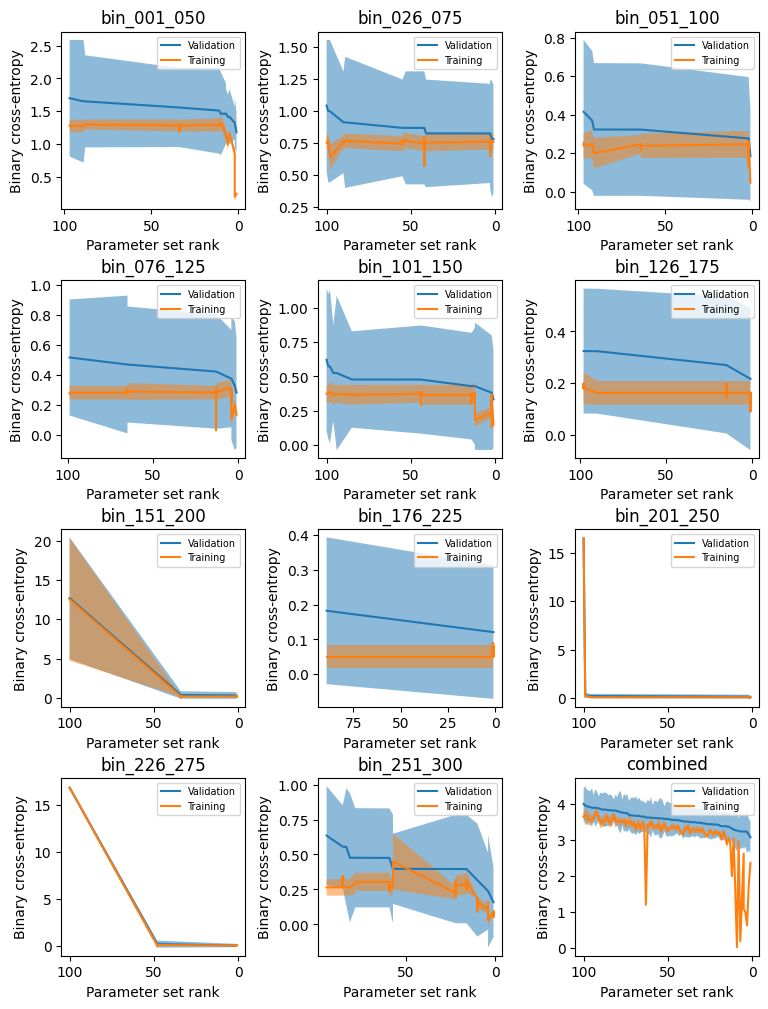

In [9]:
# Plot the results
plot_funcs.plot_hyperparameter_tuning(cv_results).show()

### 3.3. Winning models comparison to baseline

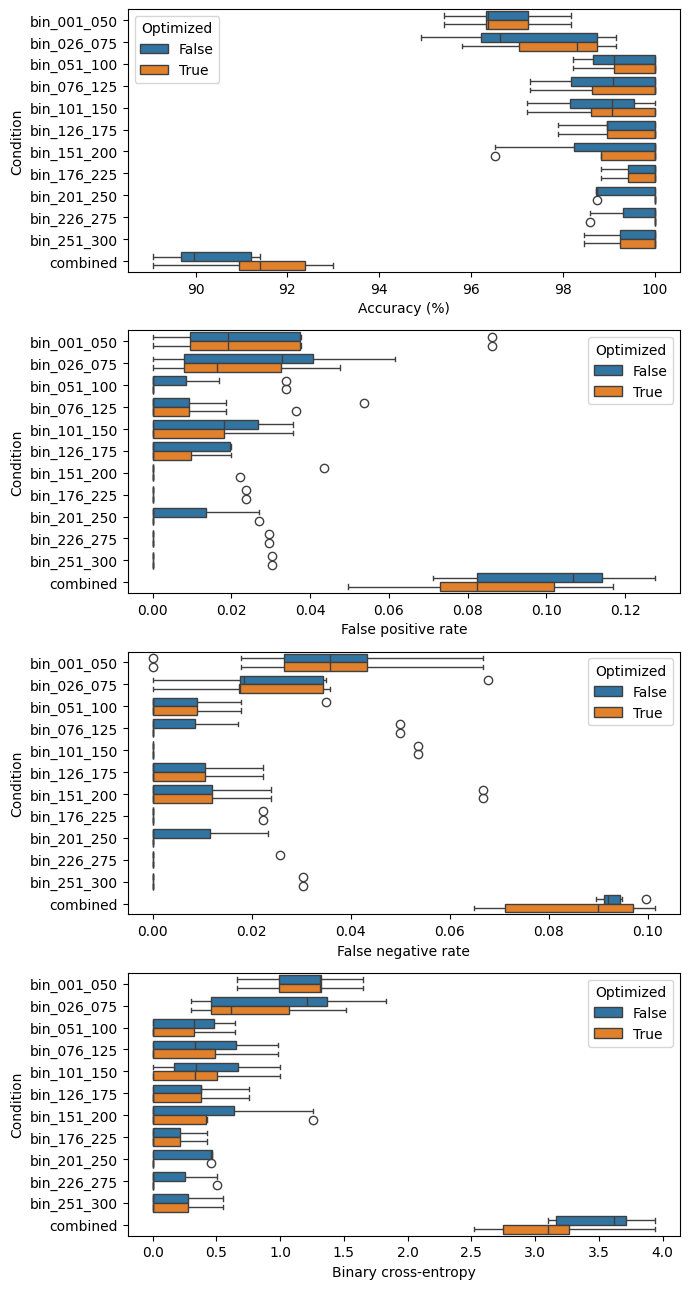

In [10]:
# First we need to go through the hyperparameter optimization results and get
# them formatted so we can add them to the results from the baseline cross-validation
parsed_results = xgb_funcs.add_winners_to_parsed_results(
    cv_results, 
    parsed_results, 
    cv_folds
)

plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

Not bad - hyperparameter optimization gained us a few accuracy percentage points, especially in the short bins where we need it most. We did specify a pretty high-dimensional parameter space, so set's do a bigger, longer run with more iterations overnight tonight.

### 3.4. Winning models evaluation on hold-out test data

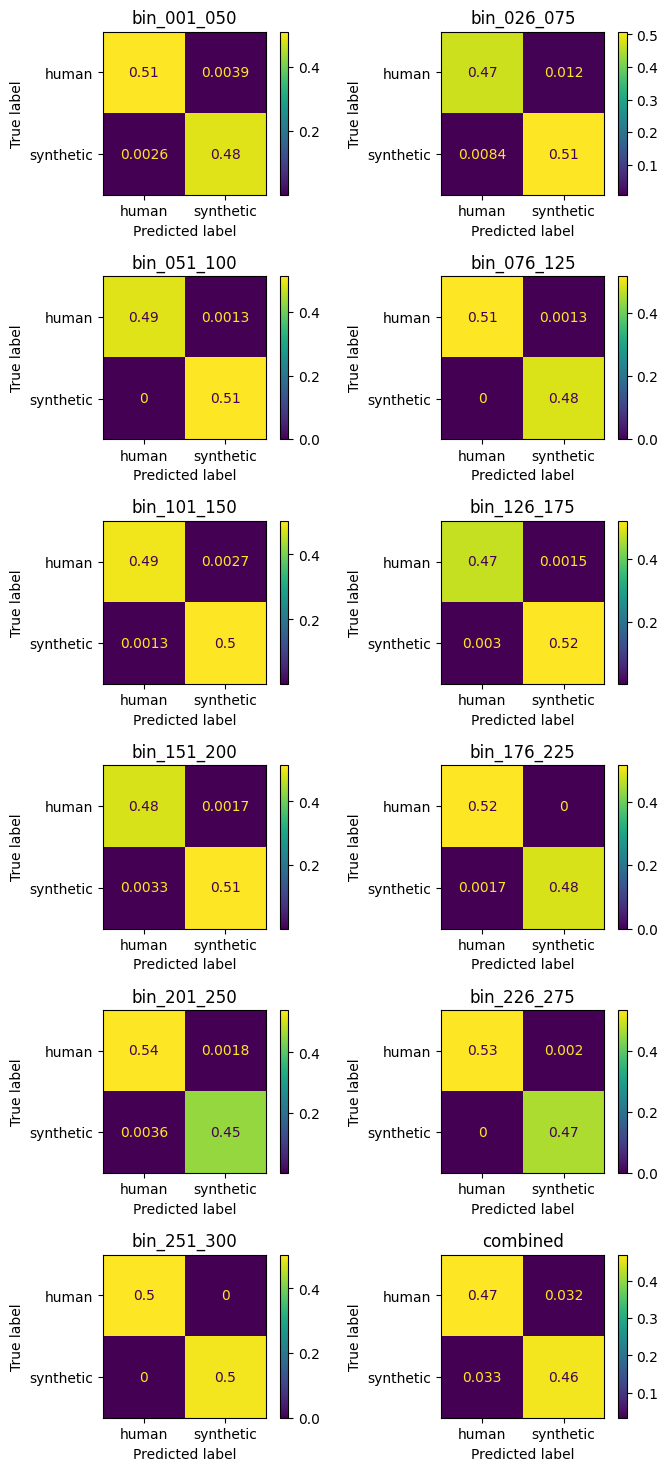

In [11]:
# Plot confusion matrix for hold-out test data in each bin
plot_funcs.plot_testing_confusion_matrices(winners, input_file).show()

Wow, looks great! Performance on the test data is as good as or better than expected from cross-validation. Over fitting is not obviously a concern.

Let's move on to setting up the stage II classifiers. Plan here is as described above - we need to:

1. Add the class probability output from both applicable stage I classifiers to each fragment as a new training feature.
2. Build and train a second set of classifiers that correspond to the bin overlaps and take the original features plus the class probabilities added in step 1.